# Classification with NN

In [111]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.python.keras.utils.np_utils import to_categorical

### Preliminary functions
The following functions are useful in many sections of this notebook, therefore they
are put here at the beginning

Function to discretize the categorical attributes:

In [112]:
#input: the dataset and the list of variables' names to discretize
def discretize_data(dataset, variables):
    for variable in variables:
        #get the unique variable's values
        var = sorted(dataset[variable].unique())

        #generate a mapping from the variable's values to the number representation
        mapping = dict(zip(var, range(0, len(var) + 1)))

        #add a new column with the number representation of the variable
        dataset[variable+'_num'] = dataset[variable].map(mapping).astype(int)

    return dataset

Function to create the NN model:

In [113]:
# Creates and returns a Keras NN model
def create_nn():
    """
    Characteristics:
        * 4 fully connected layers
            * the first 3 have 32 units
            * the last one has as many units as the number of classes, thus 3

        * activation function:
            * ReLU for the first 3 layers
            * Softmax for the output layer

        * Dropout of 0.2 is applied after every layer
    """
    model = Sequential()
    model.add(Dense(32, activation='relu', input_shape=(1,13)))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(3, activation='softmax'))
    return model

Function to compile and fit the NN model:

In [114]:
def compile_fit(model, training_set, training_labels, epochs):
    """
    Compile and fits the model

    :param training_labels:
    :param training_set:
    :param model: Keras NN model to train
    :return: history of training to plot the metrics
    """
    model.compile(
        loss='categorical_crossentropy',
        optimizer='adam',
        metrics=['accuracy']
    )
    print(training_labels[0])
    hist = model.fit(
        training_set,
        training_labels,
        epochs=epochs,
        batch_size=32,
        validation_split=0.2,
        verbose=1
    )
    return hist

Function to plot the training results:

In [115]:
def plot_train_results(train_history):
    acc = train_history.history['accuracy']
    val_acc = train_history.history['val_accuracy']
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.plot(epochs, acc, 'b', label='Training Accuracy')
    plt.plot(epochs, val_acc, 'bo', label='Validation Accuracy')
    plt.plot(epochs, loss, 'r', label='Training Loss')
    plt.plot(epochs, val_loss, 'ro', label='Validation Loss')
    plt.title('Training and validation Acc')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy & Loss')
    plt.legend()
    plt.show()

Function to create a report of the classification precision, recall, F1-score, support

In [116]:
# Function to create reports on the classification results
def report_scores(targets, predictions):
    classes = ['High_Spend','Low_Spend','Med_Spend']
    print(
        classification_report(
            targets,
            predictions,
            target_names=classes
        )
    )

## Base dataframe
Labels come from _K-means_ clustering algorithm

In [117]:
# Base dataframe
df = pd.read_csv('datasets/clustered_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MaxOrderMonth   4333 non-null   object 
 13  Label           4333 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 507.8+ KB


In [118]:
# discretize and delete the categorical attributes
df = discretize_data(df,['MaxOrderMonth','Label'])
print(f"Label num for High_Spend: {int(df[df['Label'] == 'High_Spend']['Label_num'].unique())}")
print(f"Label num for Low_Spend: {int(df[df['Label'] == 'Low_Spend']['Label_num'].unique())}")
print(f"Label num for Med_Spend: {int(df[df['Label'] == 'Med_Spend']['Label_num'].unique())}")

Label num for High_Spend: 0
Label num for Low_Spend: 1
Label num for Med_Spend: 2


In [119]:
# Drop categorical columns and keep only the corresponding numerical ones
df.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   TProd              4333 non-null   int64  
 1   DProd              4333 non-null   int64  
 2   MeanProdOrder      4333 non-null   float64
 3   TSale              4333 non-null   float64
 4   MinPSale           4333 non-null   float64
 5   MaxPSale           4333 non-null   float64
 6   MeanSaleOrder      4333 non-null   float64
 7   TRProd             4333 non-null   int64  
 8   MeanPSale          4333 non-null   float64
 9   TOrder             4333 non-null   int64  
 10  SETSaleQta         4333 non-null   float64
 11  SESaleQtaOrder     4333 non-null   float64
 12  MaxOrderMonth_num  4333 non-null   int32  
 13  Label_num          4333 non-null   int32  
dtypes: float64(8), int32(2), int64(4)
memory usage: 473.9 KB


In [120]:
# Remove the labels from the dataframe and store them in a variable (pandas.Series)
labels = df.pop('Label_num')

<AxesSubplot:>

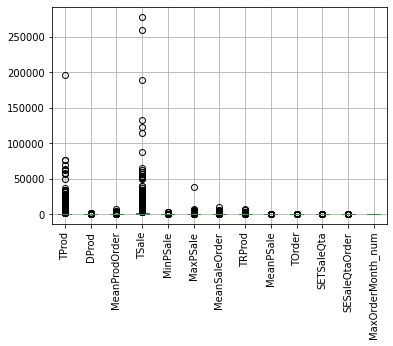

In [121]:
df.boxplot(rot=90)

Normalize the dataset

<AxesSubplot:>

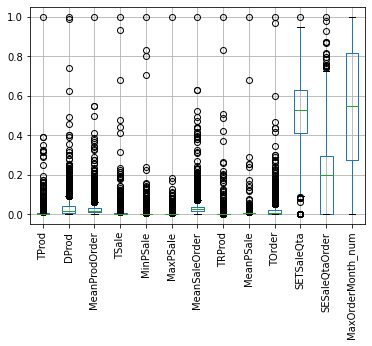

In [122]:
cols = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df.values)
df = pd.DataFrame(df, columns=cols)
df.boxplot(rot=90)

Divide the dataframe to create training and testing sets

In [123]:
train_set, test_set, train_labels, test_labels = train_test_split(df, labels, stratify=labels, test_size=0.30)

In [124]:
assert(len(train_set) == len(train_labels))
assert(len(test_set) == len(test_labels))
print(f"{len(train_labels)} training samples:")
print(f"\t- {len(train_labels[train_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(train_labels[train_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(train_labels[train_labels == 2])} samples for the class Med_Spend")
print(f"\n{len(test_labels)} test samples:")
print(f"\t- {len(test_labels[test_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(test_labels[test_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(test_labels[test_labels == 2])} samples for the class Med_Spend")

3033 training samples:
	- 18 samples for the class High_Spend
	- 2701 samples for the class Low_Spend
	- 314 samples for the class Med_Spend

1300 test samples:
	- 8 samples for the class High_Spend
	- 1157 samples for the class Low_Spend
	- 135 samples for the class Med_Spend


In [125]:
# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels, 3)

Create the Neural Network, compile it and train it

In [126]:
nn = create_nn()
history = compile_fit(nn, train_set, train_labels, epochs=20)

[0. 1. 0.]
Epoch 1/20
76/76 [==============================] - 0s 3ms/step - loss: 0.7529 - accuracy: 0.8611 - val_loss: 0.4059 - val_accuracy: 0.9028
Epoch 2/20
76/76 [==============================] - 0s 1ms/step - loss: 0.4279 - accuracy: 0.8875 - val_loss: 0.3405 - val_accuracy: 0.9028
Epoch 3/20
76/76 [==============================] - 0s 1ms/step - loss: 0.3940 - accuracy: 0.8875 - val_loss: 0.3167 - val_accuracy: 0.9028
Epoch 4/20
76/76 [==============================] - 0s 1ms/step - loss: 0.3567 - accuracy: 0.8875 - val_loss: 0.2856 - val_accuracy: 0.9028
Epoch 5/20
76/76 [==============================] - 0s 1ms/step - loss: 0.3

Plot the training results:

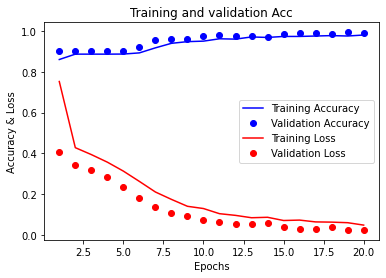

In [127]:
plot_train_results(history)

Test the model on the test set

In [128]:
test_predictions = nn.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)
report_scores(test_labels, test_predictions)

              precision    recall  f1-score   support

  High_Spend       1.00      1.00      1.00         8
   Low_Spend       0.99      1.00      1.00      1157
   Med_Spend       1.00      0.93      0.97       135

   micro avg       0.99      0.99      0.99      1300
   macro avg       1.00      0.98      0.99      1300
weighted avg       0.99      0.99      0.99      1300
 samples avg       0.99      0.99      0.99      1300



## Dataframe coming from Fuzzy C-Means
Labels come from _Fuzzy C-Means_ clustering algorithm

In [129]:
# Base dataframe
df = pd.read_csv('datasets/clustered_fuzzy_dataframe.csv', sep='\t', index_col=0)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4333 entries, 17850 to 12713
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   TProd           4333 non-null   int64  
 1   DProd           4333 non-null   int64  
 2   MeanProdOrder   4333 non-null   float64
 3   TSale           4333 non-null   float64
 4   MinPSale        4333 non-null   float64
 5   MaxPSale        4333 non-null   float64
 6   MeanSaleOrder   4333 non-null   float64
 7   TRProd          4333 non-null   int64  
 8   MeanPSale       4333 non-null   float64
 9   TOrder          4333 non-null   int64  
 10  SETSaleQta      4333 non-null   float64
 11  SESaleQtaOrder  4333 non-null   float64
 12  MaxOrderMonth   4333 non-null   object 
 13  Label           4333 non-null   object 
dtypes: float64(8), int64(4), object(2)
memory usage: 507.8+ KB


In [130]:
# discretize and delete the categorical attributes
df = discretize_data(df,['MaxOrderMonth','Label'])
print(f"Label num for High_Spend: {int(df[df['Label'] == 'High_Spend']['Label_num'].unique())}")
print(f"Label num for Low_Spend: {int(df[df['Label'] == 'Low_Spend']['Label_num'].unique())}")
print(f"Label num for Med_Spend: {int(df[df['Label'] == 'Med_Spend']['Label_num'].unique())}")

# Drop categorical columns and keep only the corresponding numerical ones
df.drop(columns=['MaxOrderMonth','Label'], inplace=True, errors='ignore')

# Remove the labels from the dataframe and store them in a variable (pandas.Series)
labels = df.pop('Label_num')

#Normalize the dataset
cols = df.columns
scaler = MinMaxScaler()
df = scaler.fit_transform(df.values)
df = pd.DataFrame(df, columns=cols)

# Divide the dataframe to create training and testing sets
train_set, test_set, train_labels, test_labels = train_test_split(df, labels, stratify=labels, test_size=0.30)

assert(len(train_set) == len(train_labels))
assert(len(test_set) == len(test_labels))
print(f"\n{len(train_labels)} training samples:")
print(f"\t- {len(train_labels[train_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(train_labels[train_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(train_labels[train_labels == 2])} samples for the class Med_Spend")
print(f"\n{len(test_labels)} test samples:")
print(f"\t- {len(test_labels[test_labels == 0])} samples for the class High_Spend")
print(f"\t- {len(test_labels[test_labels == 1])} samples for the class Low_Spend")
print(f"\t- {len(test_labels[test_labels == 2])} samples for the class Med_Spend")

# Encode labels with one-hot
train_labels = to_categorical(train_labels, 3)
test_labels = to_categorical(test_labels, 3)

Label num for High_Spend: 0
Label num for Low_Spend: 1
Label num for Med_Spend: 2

3033 training samples:
	- 113 samples for the class High_Spend
	- 2155 samples for the class Low_Spend
	- 765 samples for the class Med_Spend

1300 test samples:
	- 49 samples for the class High_Spend
	- 923 samples for the class Low_Spend
	- 328 samples for the class Med_Spend


Create the Neural Network, compile it and train it

In [131]:
nn = create_nn()
history = compile_fit(nn, train_set, train_labels, epochs=30)

[0. 1. 0.]
Epoch 1/30
76/76 [==============================] - 0s 3ms/step - loss: 0.8588 - accuracy: 0.7045 - val_loss: 0.7707 - val_accuracy: 0.6870
Epoch 2/30
76/76 [==============================] - 0s 2ms/step - loss: 0.7178 - accuracy: 0.7164 - val_loss: 0.7348 - val_accuracy: 0.6870
Epoch 3/30
76/76 [==============================] - 0s 2ms/step - loss: 0.6759 - accuracy: 0.7148 - val_loss: 0.6857 - val_accuracy: 0.6870
Epoch 4/30
76/76 [==============================] - 0s 2ms/step - loss: 0.6269 - accuracy: 0.7176 - val_loss: 0.6049 - val_accuracy: 0.6886
Epoch 5/30
76/76 [==============================] - 0s 1ms/step - loss: 0.5

Plot the training results:

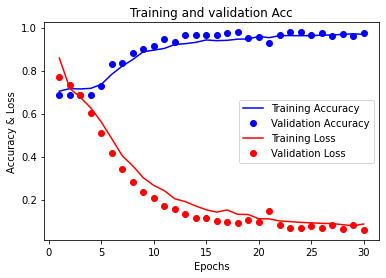

In [132]:
plot_train_results(history)

Test the model on the test set

In [133]:
test_predictions = nn.predict_classes(test_set)
test_predictions = to_categorical(test_predictions, 3)
report_scores(test_labels, test_predictions)

              precision    recall  f1-score   support

  High_Spend       1.00      0.94      0.97        49
   Low_Spend       1.00      0.99      0.99       923
   Med_Spend       0.96      1.00      0.98       328

   micro avg       0.99      0.99      0.99      1300
   macro avg       0.99      0.97      0.98      1300
weighted avg       0.99      0.99      0.99      1300
 samples avg       0.99      0.99      0.99      1300

